# Text Classification!

In [83]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#lines below let allow multiple results from a line of code to be shown e.g. df.head() + df.columns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#this allows us to see all of our columns or rows in jupyter notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [84]:
pwd

'C:\\Users\\Sam Cannon\\Desktop\\Python\\Udemy Courses\\NLP\\UPDATED_NLP_COURSE\\TextFiles'

In [85]:
#read in our data
os.chdir('C:\\Users\\Sam Cannon\\Desktop\\Python\\Udemy Courses\\NLP\\UPDATED_NLP_COURSE\\TextFiles')
df = pd.read_csv('smsspamcollection.tsv', sep='\t') #tab separated, so sep='\t' indicates that 
df.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [5]:
df.describe()

,length,punct
count,5572.000000,5572.000000
mean,80.489950,4.177495
std,59.942907,4.623919
min,2.000000,0.000000
25%,36.000000,2.000000
50%,62.000000,3.000000
75%,122.000000,6.000000
max,910.000000,133.000000


In [7]:
#get a profile report
import pandas_profiling 
df.profile_report()

In [9]:
# Printing the percentage of missing values per column
def percent_missing(dataframe):
    '''
    Prints the percentage of missing values for each column in a dataframe
    '''
    # Summing the number of missing values per column and then dividing by the total
    sumMissing = dataframe.isnull().values.sum(axis=0)
    pctMissing = sumMissing / dataframe.shape[0]
    
    if sumMissing.sum() == 0:
        print('No missing values')
    else:
        # Looping through and printing out each columns missing value percentage
        print('Percent Missing Values:', '\n')
        for idx, col in enumerate(dataframe.columns):
            if sumMissing[idx] > 0:
                print('{0}: {1:.2f}%'.format(col, pctMissing[idx] * 100))

In [10]:
percent_missing(df)

No missing values


In [14]:
df.label.unique()

array(['ham', 'spam'], dtype=object)

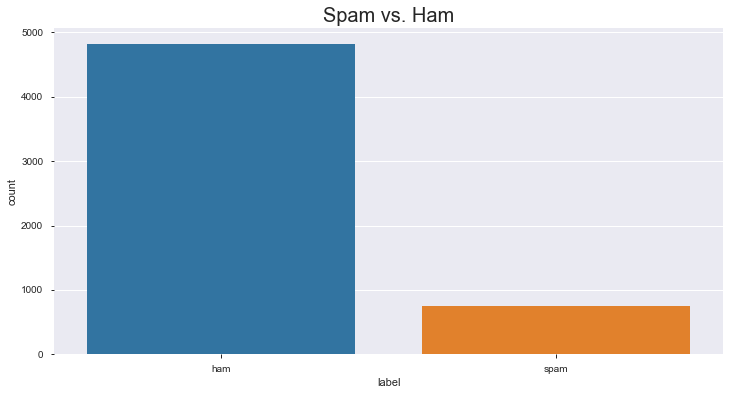

In [33]:
#visualize label, we can see that there is quite a class imbalance, but we would most likely want to optimize for detecting spam, so for recall
plt.figure(figsize = (12, 6))
sns.countplot(df['label'])
plt.title('Spam vs. Ham', fontsize = 20);

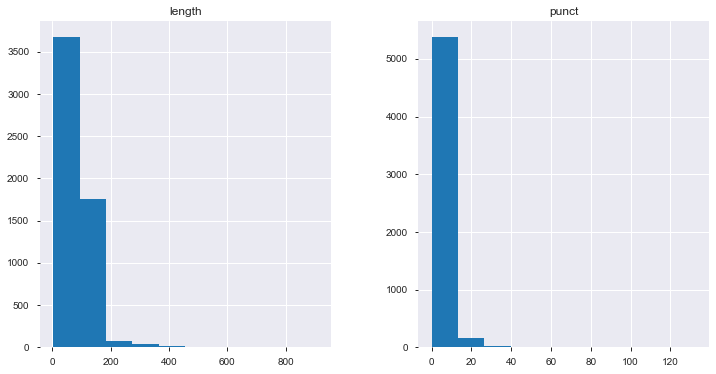

In [32]:
#the data is also highly skewed
df.hist(figsize = (12, 6));

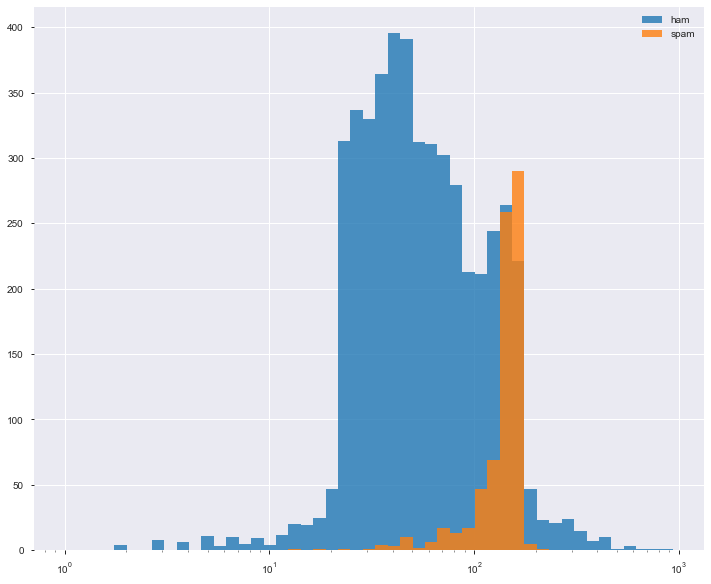

In [41]:
#plot the data labels using a logarithmic scale since they are so skewed, we can see here that spam message lengths are actually quite longer than ham, interesting
#to see! This is a useful feature for sure
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (12, 10))
plt.xscale('log')
bins = 1.15**(np.arange(0,50))
plt.hist(df[df['label']=='ham']['length'], bins = bins,alpha=0.8)
plt.hist(df[df['label']=='spam']['length'],bins=bins,alpha=0.8)
plt.legend(('ham','spam'));

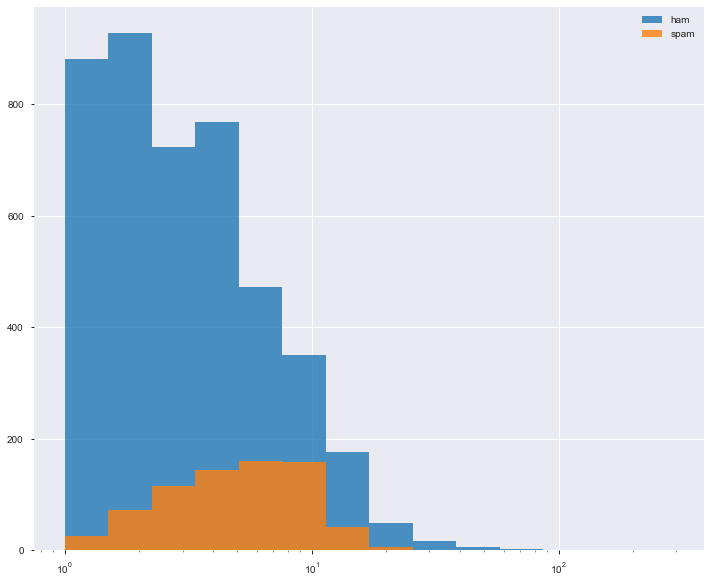

In [46]:
#now look at the punctuation
plt.figure(figsize = (12, 10))
plt.xscale('log')
bins = 1.5**(np.arange(0,15))
plt.hist(df[df['label']=='ham']['punct'],bins=bins,alpha=0.8)
plt.hist(df[df['label']=='spam']['punct'],bins=bins,alpha=0.8)
plt.legend(('ham','spam'));

# Modeling

In [86]:
#lets create a really rough machine learning model with only the numeric feature data
from sklearn.model_selection import train_test_split

In [87]:
X = df.drop(['label', 'message'], axis = 1)
y = df.label

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

In [89]:
#lets start with a simple logistic regression classifier
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(solver='liblinear') #using liblinear for small data set

lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [90]:
#lets see a classification report, it appears as though we have terrible recall
from sklearn import metrics
predictions = lr_model.predict(X_test)
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

         ham       0.87      0.97      0.91      1448
        spam       0.10      0.02      0.04       224

    accuracy                           0.84      1672
   macro avg       0.48      0.50      0.48      1672
weighted avg       0.76      0.84      0.80      1672



In [91]:
#look at a confusion matrix (True/Predicted) with predicted values on the side and true on the top
# You can make the confusion matrix less confusing by adding labels:
df_pred = pd.DataFrame(metrics.confusion_matrix(y_test,predictions), index=['ham','spam'], columns=['ham','spam'])
df_pred

,ham,spam
ham,1405,43
spam,219,5


In [96]:
#while train test splits are ok, we should always cross validate with smaller data sets, here we are using recall as our scoring metric and WOW it is terrible, 
#I bet it does better once we use the text data in the dataframe!
mapper = {'ham':0, 'spam':1}
df['label'] = df['label'].replace(mapper) #had to relabel for us to be able to use cross_val_score with recall scoring metric

X = df.drop(['label', 'message'], axis = 1)
y = df.label

from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
import numpy.random as nr

nr.seed(3345)
folds = KFold(n_splits = 10, shuffle = True)

cross_val_score(lr_model, X, y, cv = folds, scoring = 'recall')
np.mean(cross_val_score(lr_model, X, y, cv = folds, scoring = 'recall'))

array([0.02564103, 0.04054054, 0.        , 0.        , 0.        ,
       0.03333333, 0.01333333, 0.02898551, 0.02380952, 0.01369863])

0.012416604297276427

In [104]:
#How does a SVM do? It does a lot better than the logistic regression model nut its still only predicting half the spam emails 
from sklearn.svm import SVC
svc_model = SVC()
svc_model.fit(X_train, y_train)
svc_predictions = svc_model.predict(X_test)
print(metrics.confusion_matrix(y_test,svc_predictions))
print(metrics.classification_report(y_test, svc_predictions))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

[[1373   75]
 [ 121  103]]
              precision    recall  f1-score   support

         ham       0.92      0.95      0.93      1448
        spam       0.58      0.46      0.51       224

    accuracy                           0.88      1672
   macro avg       0.75      0.70      0.72      1672
weighted avg       0.87      0.88      0.88      1672



In [105]:
#much better recall, but only a little better than half the time essentially
cross_val_score(svc_model, X, y, cv = folds, scoring = 'recall')
np.mean(cross_val_score(svc_model, X, y, cv = folds, scoring = 'recall'))

array([0.63291139, 0.50704225, 0.52702703, 0.44871795, 0.44594595,
       0.57692308, 0.41071429, 0.44827586, 0.58536585, 0.47058824])

0.515810097021989

# Feature Extraction From Text
- This will allow us to create a much better model 

We are going to use TF-IDF (term frequency,  inverse document frequency) to break out text features down. There is a lot of math that goes into TF-IDF, but I will simply say here that it is a measure of how frequently a word occurs in a document or corpus or documents where the most frequent words that occur are treated differently. For more information on TF-IDF, visit [TfidVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [108]:
df.head()

,label,message,length,punct
0,0,"Go until jurong point, crazy.. Available only ...",111,9
1,0,Ok lar... Joking wif u oni...,29,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,0,U dun say so early hor... U c already then say...,49,6
4,0,"Nah I don't think he goes to usf, he lives aro...",61,2


In [115]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

#only use the text feature now
feature = df['message']
label = df['label']
X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size = .3, random_state = 44)

X_train_tfidf = vectorizer.fit_transform(X_train) # remember to use the original X_train set
X_train_tfidf.shape

(3900, 7301)

## Build a Pipeline
Remember that only our training set has been vectorized into a full vocabulary. In order to perform an analysis on our test set we'll have to submit it to the same procedures. Fortunately scikit-learn offers a [**Pipeline**](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) class that behaves like a compound classifier.

In [142]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

# Feed the training data through the pipeline
text_clf.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
               

In [143]:
pred = text_clf.predict(X_test)

In [144]:
# Print a classification report
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1445
           1       0.98      0.90      0.94       227

    accuracy                           0.98      1672
   macro avg       0.98      0.95      0.97      1672
weighted avg       0.98      0.98      0.98      1672



In [145]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,pred))

[[1441    4]
 [  22  205]]


This linear SVC did much better with the text feature than with the numeric features we used earlier! We clearly unearthed a lot of information from our text feature